In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "heart-failure-clinical-data"

## Intro
Hello. I am completely new to data science and statistics. I have only taken two statistics classes: intro to statistics and programming in R, so I don't really know if I'm doing things in the best way possible and am open to feedback.

## Exploratory Data Analysis and Feature Selection
Before trying to make a model that can predict the survival of a patient with heart failure, we want to first look at the data, make sure that it's in the structure that we want, and then take a look at it to make sure that our data can be used to make a good model.

In [2]:
heart_data <- read.csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
head(heart_data)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,75,0,582,0,20,1,265000,1.9,130,1,0,4,1
2,55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
3,65,0,146,0,20,0,162000,1.3,129,1,1,7,1
4,50,1,111,0,20,0,210000,1.9,137,1,0,7,1
5,65,1,160,1,20,0,327000,2.7,116,0,0,8,1
6,90,1,47,0,40,1,204000,2.1,132,1,1,8,1


First, let's see if any columns have any missing data.

In [3]:
apply(heart_data, 2, function(col){
    sum(is.na(col))
})

age                  anaemia creatinine_phosphokinase 
                       0                        0                        0 
                diabetes        ejection_fraction      high_blood_pressure 
                       0                        0                        0 
               platelets         serum_creatinine             serum_sodium 
                       0                        0                        0 
                     sex                  smoking                     time 
                       0                        0                        0 
             DEATH_EVENT 
                       0

Let's also look at what data type the columns are stored as.

In [4]:
str(heart_data)

'data.frame':	299 obs. of  13 variables:
 $ age                     : num  75 55 65 50 65 90 75 60 65 80 ...
 $ anaemia                 : int  0 0 0 1 1 1 1 1 0 1 ...
 $ creatinine_phosphokinase: int  582 7861 146 111 160 47 246 315 157 123 ...
 $ diabetes                : int  0 0 0 0 1 0 0 1 0 0 ...
 $ ejection_fraction       : int  20 38 20 20 20 40 15 60 65 35 ...
 $ high_blood_pressure     : int  1 0 0 0 0 1 0 0 0 1 ...
 $ platelets               : num  265000 263358 162000 210000 327000 ...
 $ serum_creatinine        : num  1.9 1.1 1.3 1.9 2.7 2.1 1.2 1.1 1.5 9.4 ...
 $ serum_sodium            : int  130 136 129 137 116 132 137 131 138 133 ...
 $ sex                     : int  1 1 1 1 0 1 1 1 0 1 ...
 $ smoking                 : int  0 0 1 0 0 1 0 1 0 1 ...
 $ time                    : int  4 6 7 7 8 8 10 10 10 10 ...
 $ DEATH_EVENT             : int  1 1 1 1 1 1 1 1 1 1 ...


While there doesn't seem to be any missing data, some of our data isn't stored in the way that we want it to be. For example, `sex`, `smoking`, and `anaemia` are stored as integers rather than factors, so let's fix that to make the data easier to understand.

In [5]:
for (col in c('anaemia', 'diabetes', 'high_blood_pressure', 'smoking', 'DEATH_EVENT')) {
    heart_data[[col]][heart_data[[col]] == 0] <- "No"
    heart_data[[col]][heart_data[col] == 1] <- "Yes"
    heart_data[[col]] <- as.factor(heart_data[[col]])
}
heart_data[heart_data$sex == 0, ]$sex <- 'F'
heart_data[heart_data$sex == 1, ]$sex <- 'M'
heart_data$sex <- as.factor(heart_data$sex)

str(heart_data)

'data.frame':	299 obs. of  13 variables:
 $ age                     : num  75 55 65 50 65 90 75 60 65 80 ...
 $ anaemia                 : Factor w/ 2 levels "No","Yes": 1 1 1 2 2 2 2 2 1 2 ...
 $ creatinine_phosphokinase: int  582 7861 146 111 160 47 246 315 157 123 ...
 $ diabetes                : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 1 1 2 1 1 ...
 $ ejection_fraction       : int  20 38 20 20 20 40 15 60 65 35 ...
 $ high_blood_pressure     : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 2 1 1 1 2 ...
 $ platelets               : num  265000 263358 162000 210000 327000 ...
 $ serum_creatinine        : num  1.9 1.1 1.3 1.9 2.7 2.1 1.2 1.1 1.5 9.4 ...
 $ serum_sodium            : int  130 136 129 137 116 132 137 131 138 133 ...
 $ sex                     : Factor w/ 2 levels "F","M": 2 2 2 2 1 2 2 2 1 2 ...
 $ smoking                 : Factor w/ 2 levels "No","Yes": 1 1 2 1 1 2 1 2 1 2 ...
 $ time                    : int  4 6 7 7 8 8 10 10 10 10 ...
 $ DEATH_EVENT             : Factor w

Now, our data is in a more presentable format, and we can now analyze some of our data. First, let's make a box plot of age distributions, split by whether or not they died of heart failure. We should expect that the group that died are of older age.

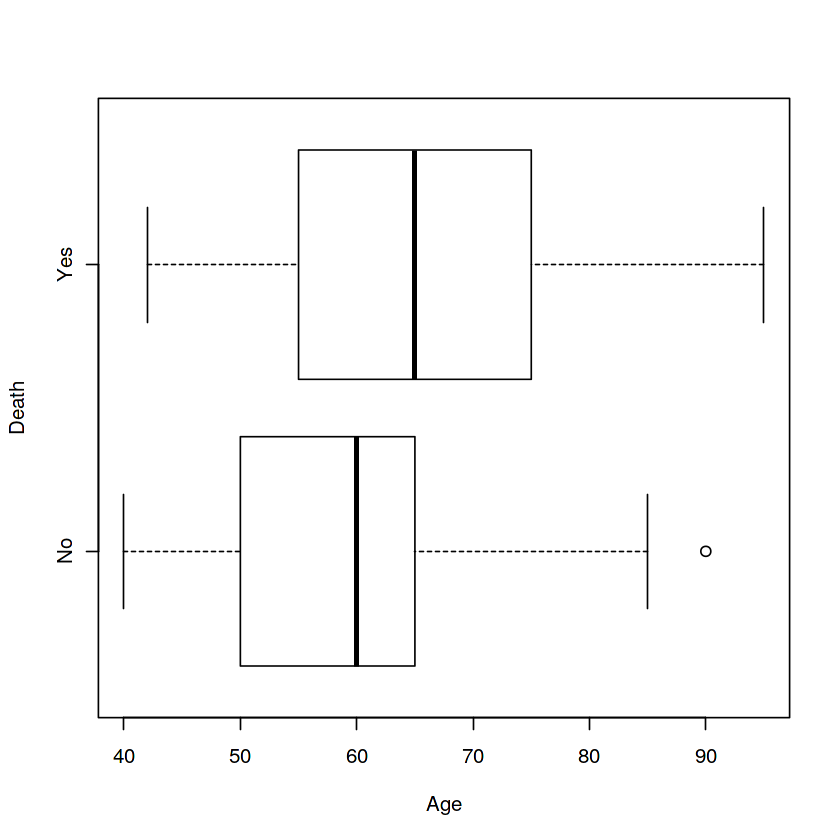

In [6]:
boxplot(age ~ DEATH_EVENT, data = heart_data, horizontal = TRUE, xlab = "Age", ylab = "Death")

Now, let's make sure that people that died of heart disease are coming from each categorical variable (i.e. `anaemia`, `smoking`, etc.). If only one group has died of heart failure, we should probably remove all other groups from the dataset.

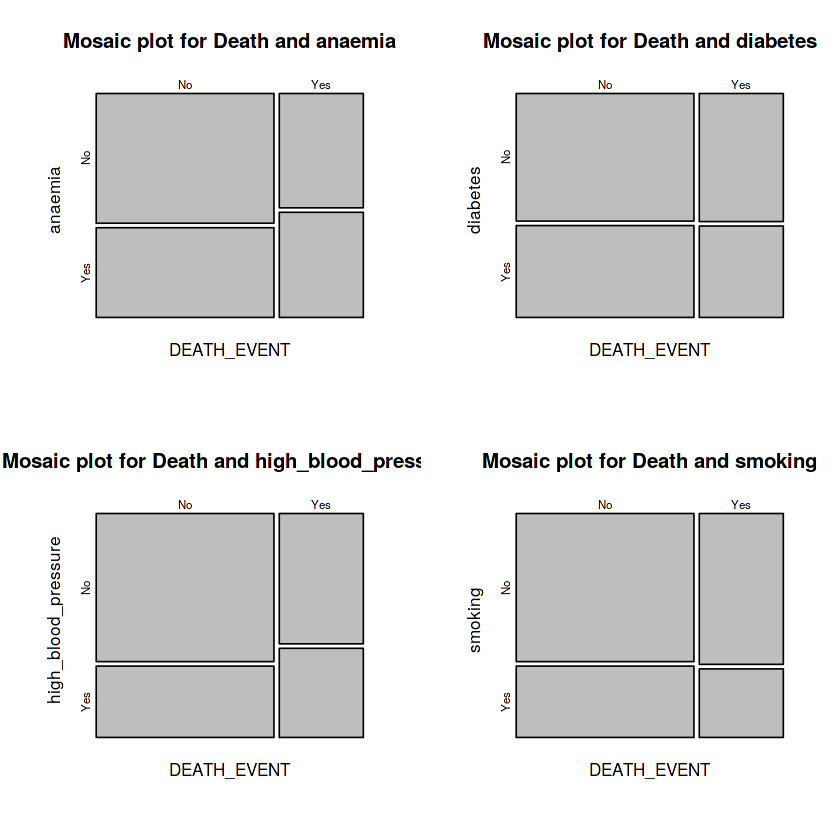

In [7]:
par(mfrow = c(2, 2))
for (category in c('anaemia', 'diabetes', 'high_blood_pressure', 'smoking')){
    my_formula <- as.formula(paste0("~ DEATH_EVENT + ", category))
    plot(xtabs(my_formula, data = heart_data), main = paste0("Mosaic plot for Death and ", category))
}

Since all of our categorical variables seem to be relatively proportional to each other, we can conclude that the data is not imbalanced.

## Building Models
To try to predict the survival of a patient, we want to build several models, but first, we need to split up our data into a training set, cross-validation set, and a test set. The training set will be used to train our model, while the cross-validation set will be used to assess which model works best. Finally, we'll use the test set as a way to see how well our final model did.

### Splitting the Data
First, we'll split the data into a training and test set. The cross-validation set is split among the training data many times during cross-validation.

In [8]:
# Shuffle the rows
set.seed(115121225)
shuffle <- sample(nrow(heart_data))
heart_data <- heart_data[shuffle, ]

# Split data into 80% Training, 20% Test
train <- heart_data[seq(floor(nrow(heart_data) * 0.8)), ]
test <- heart_data[-seq(floor(nrow(heart_data) * 0.8)), ]

c(nrow(heart_data), nrow(train), nrow(test))

[1] 299 239  60

### Logistic Regression
Now, we're going to try different machine learning algorithms on our training set in order to make the best model that can predict whether or not somebody has died of heart failure. Our first model will be logistic regression using 10-fold cross-validation. So first, we install the `caret` library, and then make our model.

In [9]:
library(caret)
log_reg_model <- train(DEATH_EVENT ~ .,
                      data = train,
                      trControl = trainControl(method = "cv", number = 10),
                      method = "glm",
                      family = binomial())
summary(log_reg_model)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress





Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2017  -0.5849  -0.2651   0.4969   2.4735  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               1.475e+01  7.134e+00   2.068  0.03867 *  
age                       4.830e-02  1.735e-02   2.784  0.00536 ** 
anaemiaYes                1.834e-01  3.870e-01   0.474  0.63558    
creatinine_phosphokinase  4.226e-04  2.372e-04   1.782  0.07477 .  
diabetesYes               1.302e-01  3.850e-01   0.338  0.73521    
ejection_fraction        -6.915e-02  1.721e-02  -4.018 5.88e-05 ***
high_blood_pressureYes   -4.486e-01  3.985e-01  -1.126  0.26035    
platelets                -1.473e-06  2.107e-06  -0.699  0.48449    
serum_creatinine          6.111e-01  1.935e-01   3.157  0.00159 ** 
serum_sodium             -1.041e-01  5.104e-02  -2.039  0.04147 *  
sexM                     -7.368e-01  4.648e-01  -1.585  0.11292    
smokingYes                4.231e-01  4.631e

From this summary, we see that the most significant variables for predicting the death of a patient include `age`, `ejection_fraction`, `serum_creatinine`, `serum_sodium`, and `time`, with the most significant ones being `time` and `ejection_fraction`. We also see that the four categorical variables we studied earlier are not as significant in predicting the death of the patient. Let's see a visualization for the `time` distribution of patients, split by whether or not they died.

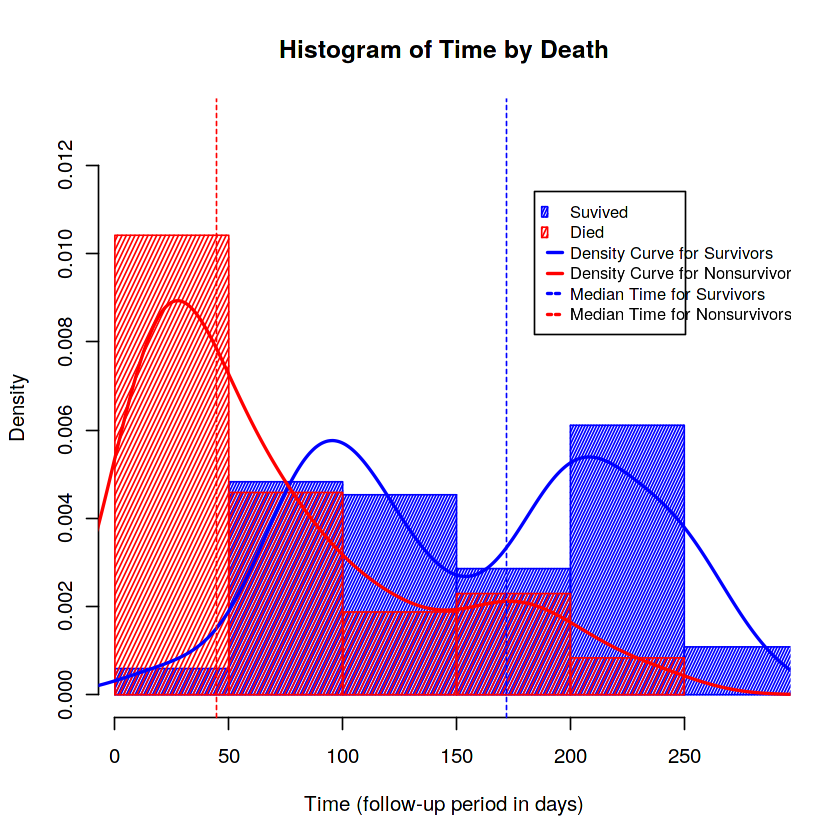

In [10]:
with(heart_data, hist(time[DEATH_EVENT == "No"],
                     prob = TRUE, density = 30,
                     col = "blue", xlab = "Time (follow-up period in days)",
                     main = "Histogram of Time by Death",
                     xlim = range(time), ylim = c(0, 0.013)))
with(heart_data, hist(time[DEATH_EVENT == "Yes"],
                     prob = TRUE, density = 20,
                     col = "red", add = TRUE))
with(heart_data, lines(density(time[DEATH_EVENT == "No"]),
                      lwd = 2,
                      col = "blue"))
with(heart_data, lines(density(time[DEATH_EVENT == "Yes"]),
                      lwd = 2,
                      col = "red"))
with(heart_data, abline(v = summary(time[DEATH_EVENT == "No"])["Median"],
                       lty = 2,
                       col = "blue"))
with(heart_data, abline(v = summary(time[DEATH_EVENT == "Yes"])["Median"],
                       lty = 2,
                       col = "red"))
legend("topright",
      c("Suvived", "Died", "Density Curve for Survivors", "Density Curve for Nonsurvivors", "Median Time for Survivors", "Median Time for Nonsurvivors"),
      col = c(NA, NA, rep(c("blue", "red"), 2)),
      fill = c("blue", "red", rep(0, 4)),
      density = c(30, 20, rep(0, 4)),
      lwd = rep(c(NA, 2, 2), rep(2, 3)),
      lty = c(NA, NA, 1, 1, 2, 2),
      border = c("blue", "red", rep(NA, 4)),
      inset = 0.15,
      cex = 0.80)


In [11]:
log_reg_test_acc <- mean(predict(log_reg_model, test) == test$DEATH_EVENT)
log_reg_test_acc

[1] 0.8333333

Thus, our score for this particular model is 83.33%. But can we do better?

### Random Forests
Now let's try building a random forest to see if it can classify whether or not a patient died of heart failure. A random forest is a machine learning model that makes use of decision trees. Decision trees are trees built from a set of data that try to predict a certain variable by asking questions at each level of a tree, and coming to a decision based on the answer to these questions. However, a decision tree alone is not a good classifier, so instead, random forests are used. Random forests are a collection of decision trees. Once a forest is made, an observation is put through every tree of the forest and whichever outcome a plurarilty of the trees decided on is the overall decision of the forest. Let's make one and see how it does.

In [12]:
library(randomForest)
set.seed(125)
rf_model <- randomForest(DEATH_EVENT ~ ., data = train, proximity = TRUE)
rf_model

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin





Call:
 randomForest(formula = DEATH_EVENT ~ ., data = train, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 17.15%
Confusion matrix:
     No Yes class.error
No  143  17   0.1062500
Yes  24  55   0.3037975

From here, we see that the default values for the number of trees in the random forest is 500, and that for each split in the tree, 3 variables are tried. We also see that the tree correctly classified 200 out of 239 patients, which is and 83.68% accuracy. This is accuracy is a good metric to use, because even though it was on the training set, every observation was only run down trees that didn't use that particular tree. We can also run this through our test set to see how it does.

In [13]:
mean(predict(rf_model, test) == test$DEATH_EVENT)

[1] 0.9

And it surprisingly does a better job on the test set than the training set, which means that random forests are good models to counter high variance and overfitting. However, let's see if we can make our random forest better by messing with some of the hyperparameters. In particular, we can change `ntree`, the number of trees in the forest, and `mtry`, the number of variables to try at each split in the tree. We'll store these into a dataframe and keep track of it.

In [14]:
trees_to_try <- c(100, 250, 500, 750, 1000, 1500)
vars_to_try <- c(1, 3, 5, 7, 9)

# Create data frame where i,jth entry is error with trees_to_try[i] trees and vars_to_try[j] vars
rf_experiment <- data.frame(matrix(0, nrow = length(trees_to_try), ncol = length(vars_to_try)))
rownames(rf_experiment) <- as.character(trees_to_try)
colnames(rf_experiment) <- as.character(vars_to_try)

for (i in seq(length(trees_to_try))) {
    for (j in seq(length(vars_to_try))) {
        set.seed(9001)
        temp_model <- randomForest(DEATH_EVENT ~ ., data = train, ntree = trees_to_try[i], mtry = vars_to_try[j])
        err <- temp_model$err.rate[nrow(temp_model$err.rate), 1]
        rf_experiment[i, j] <- err
    }
}
rf_experiment

,1,3,5,7,9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,0.2217573,0.1799163,0.1841004,0.1882845,0.1924686
250,0.2343096,0.1631799,0.1757322,0.1882845,0.2008368
500,0.2343096,0.1673640,0.1673640,0.1966527,0.1966527
750,0.2384937,0.1589958,0.1631799,0.1882845,0.1924686
1000,0.2384937,0.1589958,0.1715481,0.1841004,0.1966527
1500,0.2384937,0.1548117,0.1799163,0.1841004,0.1966527


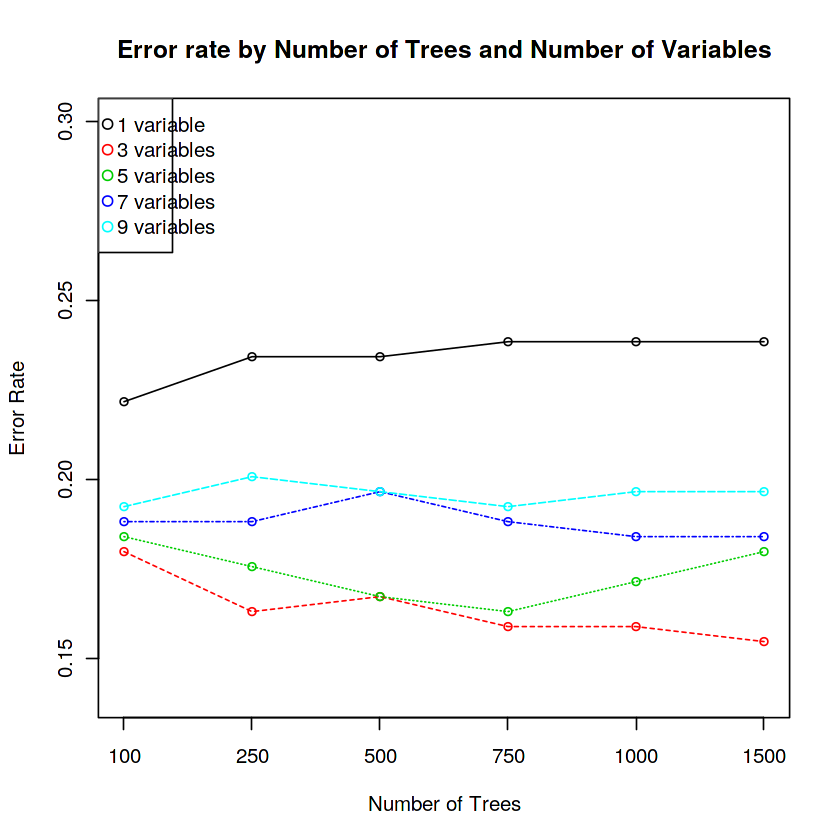

In [15]:
matplot(rf_experiment, pch = 1, cex = 0.75,
       xaxt = "n", ylab = "Error Rate", xlab = "Number of Trees", ylim = c(0.14, 0.3),
       main = "Error rate by Number of Trees and Number of Variables")
for (i in 1:5) {
    lines(x = 1:6, y = rf_experiment[, i], col = i, lty = i)
}
axis(1, at = 1:6, labels = as.character(trees_to_try))
legend("topleft",
      c("1 variable", paste0(as.character(vars_to_try[2:5]), " variables")),
      pch = rep(1, 5),
      col = 1:5)

From this graph, we see that the optimal number of variables to try at each split is 3, and that 750 trees is a good number for our random forest. Let's se how well this model does against the test set.

In [16]:
rf_model <- randomForest(DEATH_EVENT ~ ., data = train, ntree = 750, proximity = TRUE)
mean(predict(rf_model, test) == test$DEATH_EVENT)

[1] 0.8833333

Interestingly enough, despite doing better on the training set, the 750-tree model did worse on the test set, but this is by a very small percentage. Random forests are immune to overfitting, so increasing the number of trees should not make it too much worse.

### K-Nearest Neighbors Classifier
A k-nearest neighbors classifier tries to classify data points by seeing the class of the $k$ data points "closest" to it and classifying it as whatever class most are of.

In [17]:
# Load library for knn
library(class)

# Convert factors to numeric since knn needs euclidean distance. Cannot calculate euclidean distance between factors
numeric_train <- sapply(train, as.numeric)
numeric_test <- sapply(test, as.numeric)

# Create model
set.seed(231)
knn_model <- knn(numeric_train, numeric_test, cl = train$DEATH_EVENT, k = 1)

# Test accuracy
mean(knn_model == test$DEATH_EVENT)

[1] 0.5833333

Yikes, that's really bad. But, we did only choose k = 1, which meant that it was only testing the closest data value to it, so let's try different values for k and see how well it does.

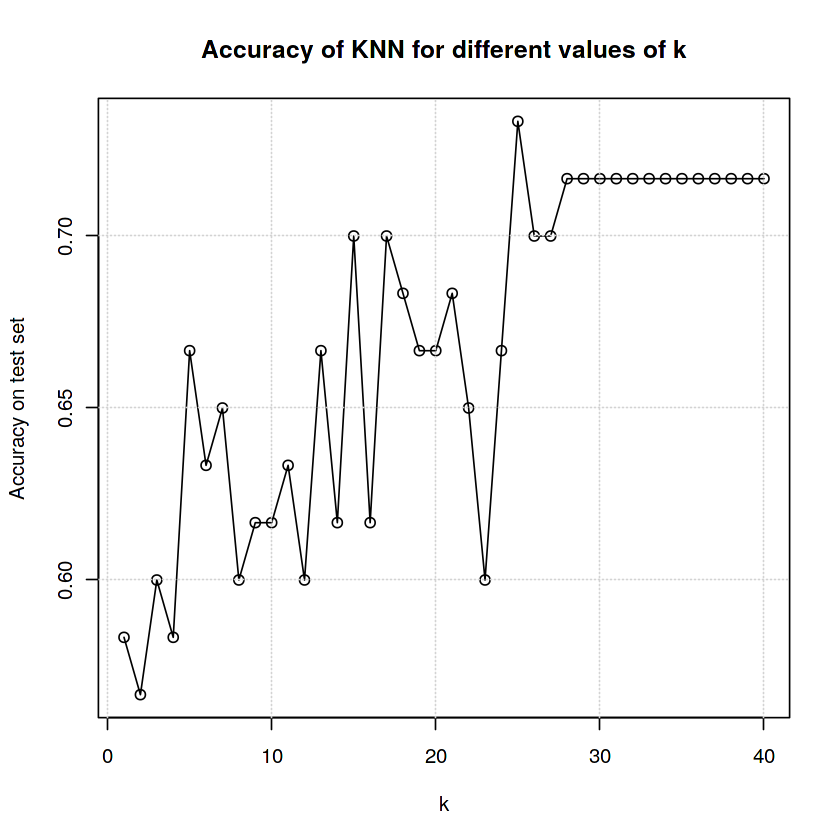

In [18]:
knn_accuracies <- vapply(1:40, function(i) {
    set.seed(115)
    temp_knn_model <- knn(numeric_train, numeric_test, cl = train$DEATH_EVENT, k = i)
    mean(temp_knn_model == test$DEATH_EVENT)
}, numeric(1))

plot(x = 1:40, y = knn_accuracies, xlab = "k", ylab = "Accuracy on test set",
    main = "Accuracy of KNN for different values of k")
lines(x = 1:40, y = knn_accuracies)
grid()

In [19]:
# Seems best for k = 25
set.seed(502)
mean(knn(numeric_train, numeric_test, cl = train$DEATH_EVENT, k = 25) == test$DEATH_EVENT)

[1] 0.7333333

KNN doesn't seem to be a very good model for this. For one, I think that I should split up the training set into a training set and a cross-validation set, then when I made the graph and tested accuracies for different values of k, I should've used the cross-validation set, then for the value of k that gives the highest accuracy on the cross-validation set, tried that against the test set to see how well it does.

## Breakdown
Based on these three models, as well as the exploratory data analysis we did at the beginning, I'm starting to see a few things. For one, I don't think that the outcome is based on how close the variables are to each other numerically, at least for some of the variables. My reasoning for this is that before we began building models, we saw that there were a few variables that did not have a very strong impact on whether or not a patient survived heart failure, so I thought that perhaps that variable alone wouldn't be able to tell us much, but, if combined with another variable, could lead to some results. This was seen when we studied the p-values for logistic regression, as well as seeing that a random forest (a model where a decision is made based on the variables at each step), did better than the other models. In addition, logistic regression and knn are "continuous" models, where as a random forest is a "discrete" model; this is what I mean when I say that two patients being "numerically close" to each other doesn't mean that they should be part of the same class.

## Making Models: Round 2
When we ran the logistic regression algorithm, we saw that there were five variables that seemed to have a significant impact on the model: `age`, `ejection_fraction`, `serum_creatinine`, `serum_sodium`, and `time`. Let's only use these features and see how well our models do with only these variables. I think it should preform better, since we're now only looking at what's important, rather than variables that are just noisy and don't seem to affect the outcome.

In [20]:
features <- c("age", "ejection_fraction", "serum_creatinine", "serum_sodium", "time")
train <- train[, c(features, "DEATH_EVENT")]
test <- test[, c(features, "DEATH_EVENT")]
head(train)

,age,ejection_fraction,serum_creatinine,serum_sodium,time,DEATH_EVENT
,<dbl>,<int>,<dbl>,<int>,<int>,<fct>
201,63,45,0.7,137,186,No
76,60,20,0.7,139,73,Yes
143,50,30,0.9,132,109,No
45,60,60,1.1,142,33,Yes
209,60,40,1.0,141,187,No
107,55,45,1.3,137,88,No


In [21]:
# Logistic Regression: Round 2
log_reg_model2 <- train(DEATH_EVENT ~ .,
                      data = train,
                      trControl = trainControl(method = "cv", number = 10),
                      method = "glm",
                      family = binomial())
summary(log_reg_model2)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0910  -0.6467  -0.2657   0.5944   2.6248  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       12.839992   6.627729   1.937  0.05271 .  
age                0.041438   0.016116   2.571  0.01013 *  
ejection_fraction -0.065135   0.016428  -3.965 7.35e-05 ***
serum_creatinine   0.595512   0.187711   3.172  0.00151 ** 
serum_sodium      -0.091628   0.047639  -1.923  0.05443 .  
time              -0.018294   0.003026  -6.045 1.49e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 303.32  on 238  degrees of freedom
Residual deviance: 191.41  on 233  degrees of freedom
AIC: 203.41

Number of Fisher Scoring iterations: 5


In [22]:
mean(predict(log_reg_model2, test) == test$DEATH_EVENT)

[1] 0.8666667

Not bad, we got about a 3.33% increase compared to last time. Let's see how our random forest does.

In [23]:
set.seed(1234)
rf_model2 <- randomForest(DEATH_EVENT ~ ., data = train, proximity = TRUE)
rf_model2


Call:
 randomForest(formula = DEATH_EVENT ~ ., data = train, proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 16.32%
Confusion matrix:
     No Yes class.error
No  139  21   0.1312500
Yes  18  61   0.2278481

Our OOB error is slightly lower than last time, but the number of variables at each split also defaulted to 2. Let's run the experiment like we did last time and see which parameters we should use.

,1,2,3,4
,<dbl>,<dbl>,<dbl>,<dbl>
100,0.1924686,0.1924686,0.1589958,0.1841004
250,0.1799163,0.1757322,0.1715481,0.1799163
500,0.1757322,0.1422594,0.1715481,0.1799163
750,0.1715481,0.1506276,0.1673640,0.1799163
1000,0.1631799,0.1506276,0.1631799,0.1757322
1500,0.1589958,0.1506276,0.1631799,0.1757322


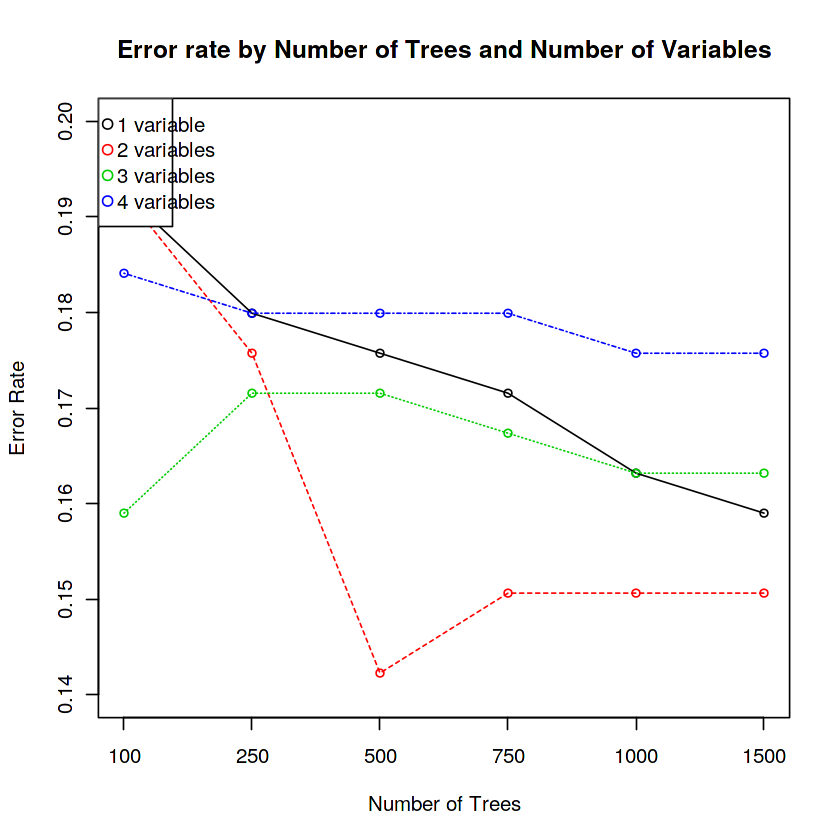

In [24]:
trees_to_try2 <- c(100, 250, 500, 750, 1000, 1500)
vars_to_try2 <- c(1, 2, 3, 4)

# Create data frame where i,jth entry is error with trees_to_try2[i] trees and vars_to_try2[j] vars
rf_experiment2 <- data.frame(matrix(0, nrow = length(trees_to_try2), ncol = length(vars_to_try2)))
rownames(rf_experiment2) <- as.character(trees_to_try2)
colnames(rf_experiment2) <- as.character(vars_to_try2)

for (i in seq(length(trees_to_try2))) {
    for (j in seq(length(vars_to_try2))) {
        set.seed(25)
        temp_model <- randomForest(DEATH_EVENT ~ ., data = train, ntree = trees_to_try2[i], mtry = vars_to_try2[j])
        err <- temp_model$err.rate[nrow(temp_model$err.rate), 1]
        rf_experiment2[i, j] <- err
    }
}

rf_experiment2

matplot(rf_experiment2, pch = 1, cex = 0.75,
       xaxt = "n", ylab = "Error Rate", xlab = "Number of Trees", ylim = c(0.14, 0.20),
       main = "Error rate by Number of Trees and Number of Variables")
for (i in 1:4) {
    lines(x = 1:6, y = rf_experiment2[, i], col = i, lty = i)
}
axis(1, at = 1:6, labels = as.character(trees_to_try2))
legend("topleft",
      c("1 variable", paste0(as.character(vars_to_try2[2:4]), " variables")),
      pch = rep(1, 4),
      col = 1:4)

Just like last time, the default number of variables to split was optimal, as well as the number of trees.

In [25]:
set.seed(25)
rf_model_final2 <- randomForest(DEATH_EVENT ~ ., data = train, ntree = 500, proximity = TRUE)
rf_model_final2
mean(predict(rf_model_final2, test) == test$DEATH_EVENT)


Call:
 randomForest(formula = DEATH_EVENT ~ ., data = train, ntree = 500,      proximity = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 14.23%
Confusion matrix:
     No Yes class.error
No  143  17   0.1062500
Yes  17  62   0.2151899

[1] 0.8833333

Here, we see that the model performed the same as it did when it had more features. I think this is due to random chance, because I forgot to set the seed every time I made the random model. I was getting different results and wondering why until I realized that the name of this model is called ***RANDOM*** forest. But hey, good for me to make mistakes now then later. Like I said, it's my first time trying this. Now, let's try knn, and this time, let's make a cross-validation set.

In [26]:
cv <- train[seq(floor(nrow(train) * 0.2)), ]
train_temp <- train[-seq(floor(nrow(train) * 0.2)), ]
c(nrow(cv), nrow(train_temp))

[1]  47 192

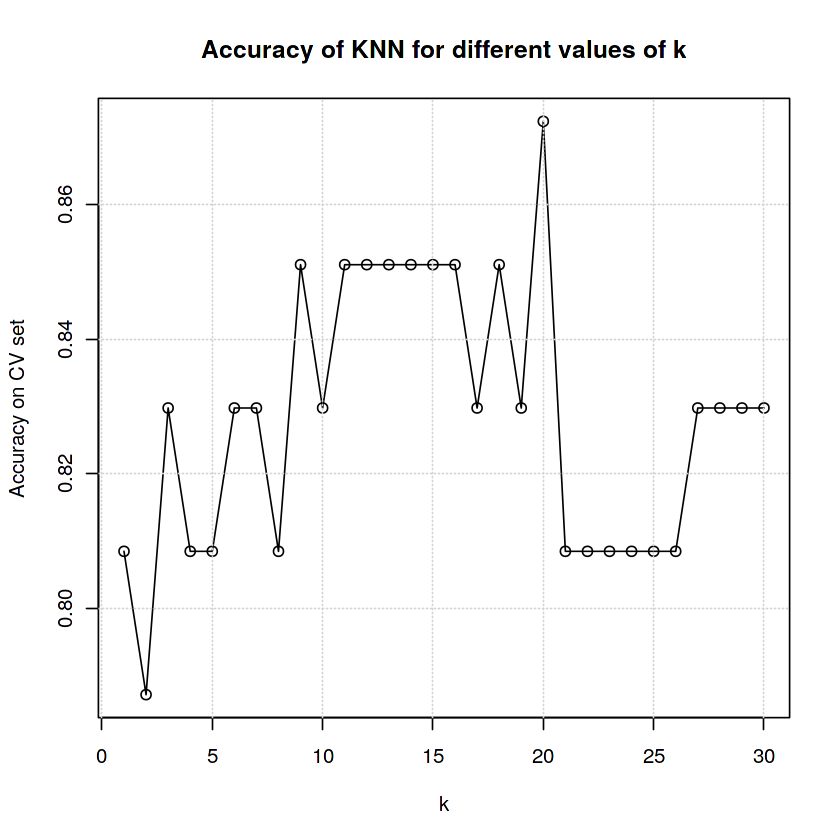

In [27]:
numeric_train_temp <- sapply(train_temp, as.numeric)
numeric_cv <- sapply(cv, as.numeric)
numeric_test <- sapply(test, as.numeric)
knn_accuracies2 <- vapply(1:30, function(i) {
    set.seed(1315)
    temp_knn_model <- knn(numeric_train_temp, numeric_cv, cl = train_temp$DEATH_EVENT, k = i)
    mean(temp_knn_model == cv$DEATH_EVENT)
}, numeric(1))
plot(x = 1:30, y = knn_accuracies2, xlab = "k", ylab = "Accuracy on CV set",
    main = "Accuracy of KNN for different values of k")
lines(x = 1:30, y = knn_accuracies2)
grid()

In [28]:
# Let's try k = 20
set.seed(1315)
knn_model2_final <- knn(numeric_train_temp, numeric_test, cl = train_temp$DEATH_EVENT, k = 20)
mean(knn_model2_final == test$DEATH_EVENT)

[1] 0.9166667

At first, I was disappointed because my accuracy was really low, and I thought I was wrong, but it turns out that when running KNN, you should use the same training set as during CV. I was wondering why I was getting accuracies in the 60's, but then I changed `numeric_train` to `numeric_train_temp` in the code above, and I got a really good accuracy! Splitting the data up, as well as turning down the number of features down out to be a very good decision here.

### Gradient Boosting
Gradient Boosting is a machine learning algorithm that can be thought of as a combination of decision trees and gradient descent. It's a sequential ensemble method in which trees are built that get better and better at predicting the residuals between the previous tree and the $y$ values of the training set.

In [29]:
library(gbm)
set.seed(991)

# GBM requires y to be 0/1
gbm_train <- train
gbm_train$DEATH_EVENT <- ifelse(train$DEATH_EVENT == 'Yes', 1, 0)
gbm_model <- gbm(formula = DEATH_EVENT ~ .,
                distribution = "bernoulli",
                data = gbm_train,
                n.trees = 1000,
                cv.folds = 5)
gbm_model

Loaded gbm 2.1.8



gbm(formula = DEATH_EVENT ~ ., distribution = "bernoulli", data = gbm_train, 
    n.trees = 1000, cv.folds = 5)
A gradient boosted model with bernoulli loss function.
1000 iterations were performed.
The best cross-validation iteration was 56.
There were 5 predictors of which 5 had non-zero influence.

In [30]:
# Predictive model comes back as numbers with unrestricted domain. Put it through the sigmoid function to convert it to raw probabilities
# Then use threshold of 0.5 to see whether or not to classify it as 1.
# Compare to test set by converting test set to numeric.
mean((1 / (exp(-1 * predict(gbm_model, test)) + 1) > 0.5) == (test$DEATH_EVENT == "Yes"))

Using 56 trees...




[1] 0.9333333

With this, we get a 93.33% accuracy, which is our best so far! Our gradient boosting model did well with 5-fold validation and 1000 trees, but let's see if increasing the number of trees has any affect on our accuracy. Let's just use the test set as a way to see whether this improves, but realistically you would use a cross-validation set with this. I think that the function for the error using gradient boosing is convex, meaning that after every iteration of gradient boosting (that is, every tree being created), the error should go lower, so while the model will get better at minimizing errors on the training set, it is prone to overfitting and not generalizing well to new examples.

Okay after trying it with different values for n.tree, I kept getting the message 'Using 56 trees...' and wondering why it wouldn't go up, but it turns out that after 56 trees, the error on the training set is so small that another iteration wouldn't decrease it by very much, so changing the number of trees won't help, but there is one hyperparameter that I just left as default, which is `interaction.depth`, which is the default depth of each tree. By default, it is 1, meaning every tree is a stump, but let's see if increasing the number to 2 or 3 will change the output. Increasing it beyond this shouldn't work well because we only have 5 features for this training set.

In [31]:
# It gets tedious typing out the sigmoid function and all that, so let's just make a function to compute the accuracy of the model on the test set

gbm_predict <- function(model, test_set = test, test_y = test$DEATH_EVENT, yes_value = "Yes") {
    sigmoid <- 1 / (1 + exp(-1 * predict(model, test_set)))
    numeric_test_y <- test_y == yes_value
    mean((sigmoid > 0.5) == numeric_test_y)
}

for (n in c(2, 3)) {
    set.seed(991)
    gbm_temp_model <- gbm(formula = DEATH_EVENT ~ .,
                         distribution = "bernoulli",
                         data = gbm_train,
                         n.trees = 100,
                         cv.folds = 5,
                         interaction.depth = n)
    print(gbm_predict(gbm_temp_model))
}

Using 53 trees...




[1] 0.9333333


Using 28 trees...




[1] 0.9166667


While increasing the depth of the tree to 2 levels didn't have any effect on the accuracy, increasing it to 3 did. Increasing the depth of the tree caused overfitting, and especially with how small this dataset is, I think that keeping the depth at 1 works best. Also, this method has been the most computationally expensive out of all the others so far, as it's taken the longest to run. I was expecting random forests to take longer considering how big I set some of the forests to be, but I think that it's because random forests are a parallel ensemble method, meaning that all the trees can be created at the same time, independently of the other, whereas gradient boosting is a sequential method, requiring one iteration to take place before the next. To compare it to coding in R, random forests can be implemented via a vectorized function (or a replicate function), whereas gradient boosting would require a for loop.

## Conclusion
For my first time trying a bunch of machine learning models in R, I thought this was a lot of fun. In doing something like this, it forced me to not only think about which models to try, but which hyperparameters I should use to make the best model, how I should clean the data before I start, and other things. I think that if I were to try something like this again, I should spend more time looking at relationships between different variables before I jump right in, as I immediately jumped into building models before looking closer at the data. I now know that some models require a little bit more preparation than others, but that could also be because I was using different packages. While reading through other notebooks for this particular dataset, I found that some models had rather high accuracies on the test set, and at first I was frustrated that I couldn't get a number that high, but I then realized that I should take those numbers with a grain of salt because the test set only consists of 60 entries, so the higher-scoring models were only predicting 2 or 3 patients better than I was, which could just be due to randomness. If the dataset was larger than those numbers would have a bit more strength behind them.